In [1]:
import pandas as pd
import numpy as np

Source: https://medium.com/analytics-vidhya/optimization-modelling-in-python-multiple-objectives-760b9f1f26ee

In [4]:
from pyomo.environ import *
import matplotlib.pyplot as plt

# max 			f1 = X1
# max 			f2 = 3 X1 + 4 X2
# constraints	X1 <= 20
#     			X2 <= 40
# 				5 X1 + 4 X2 <= 200

model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= 20)
model.C2 = Constraint(expr = model.X2 <= 40)
model.C3 = Constraint(expr = 5 * model.X1 + 4 * model.X2 <= 200)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr = model.f1 == model.X1)
model.C_f2 = Constraint(expr = model.f2 == 3 * model.X1 + 4 * model.X2)
model.O_f1 = Objective(expr = model.f1, sense=maximize)
model.O_f2 = Objective(expr = model.f2, sense=maximize)

# max f1 separately
# install glpk solver:  sudo apt-get install glpk-utils
model.O_f2.deactivate()
solver = SolverFactory('glpk')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_min = value(model.f2)

# max f2 separately
model.O_f2.activate()
model.O_f1.deactivate()
solver = SolverFactory('glpk')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_max = value(model.f2)

# apply augmented $\epsilon$-Constraint
# max   		f1 + delta*s
# constraint 	f2 - s = e
model.O_f1.activate()
model.O_f2.deactivate()

model.del_component(model.O_f1)
model.del_component(model.O_f2)

model.e = Param(initialize=0, mutable=True)
model.delta = Param(initialize=0.00001)
model.slack = Var(within=NonNegativeReals)
model.O_f1 = Objective(expr = model.f1 + model.delta * model.slack, sense=maximize)
model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

n = 100
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l, x2_l = [], []
f1_l, f2_l = [], []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
    f1_l.append(value(model.f1))
    f2_l.append(value(model.f2))
    # print(i, value(model.X1), value(model.X2), value(model.f1), value(model.slack), value(model.f2))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,4))
edge, = ax1.plot(x1_l,x2_l,'o', markersize=6, markerfacecolor='none', c='b')
shaded = ax1.fill_between(x1_l, x2_l, color='azure', alpha=0.85)
ax1.legend([(edge, shaded)], ['Decision/coordinate space'], loc='best')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_xlim((7.5,20.5))
ax1.set_ylim((24,40.5))
ax1.grid(True)

ax2.plot(f1_l, f2_l, 'o-', c='r', label='Pareto optimal front')
ax2.legend(loc='best')
ax2.set_xlabel('Objective function F1')
ax2.set_ylabel('Objective function F2')
ax2.grid(True)
fig.tight_layout()
plt.show()

solver 'glpk'


ApplicationError: No executable found for solver 'glpk'

(150, 3)
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iterati

C:\Users\Stijn Daemen\miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:231: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


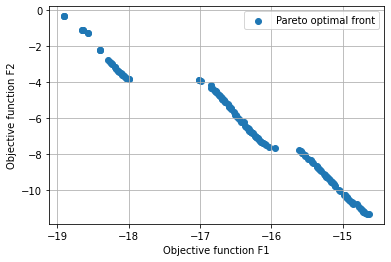

In [5]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import math

# MINIMIZATION

# Initialize random population of parent chormosomes/solutions P
def random_population(n_var, n_sol, lb, ub):
    # n_var = numver of variables
    # n_sol = number of random solutions
    # lb = lower bound
    # ub = upper bound
    pop = np.zeros((n_sol, n_var))
    for i in range(n_sol):
        pop[i,:] = np.random.uniform(lb, ub)
    
    return pop

# On each iteration, out of 2 randomly selected parents we create 2 offsprings
# by taking fraction of genes from one parent and remaining fraction from other parent 
def crossover(pop, crossover_rate):
    offspring = np.zeros((crossover_rate, pop.shape[1]))
    for i in range(int(crossover_rate/2)):
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        cutting_point = np.random.randint(1, pop.shape[1])
        offspring[2*i, 0:cutting_point] = pop[r1, 0:cutting_point]
        offspring[2*i, cutting_point:] = pop[r2, cutting_point:]
        offspring[2*i+1, 0:cutting_point] = pop[r2, 0:cutting_point]
        offspring[2*i+1, cutting_point:] = pop[r1, cutting_point:]

    return offspring    # arr(crossover_size x n_var)

# On each iteration, out of 2 randomly selected parents we create 2 offsprings
# by excahging some amount of genes/coordinates between parents
def mutation(pop, mutation_rate):
    offspring = np.zeros((mutation_rate, pop.shape[1]))
    for i in range(int(mutation_rate/2)):
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        # We select only one gene/coordinate per chromosomes/solution for mutation here.
        # For binary solutions, number of genes for mutation can be arbitrary
        cutting_point = np.random.randint(0, pop.shape[1])
        offspring[2*i] = pop[r1]
        offspring[2*i, cutting_point] = pop[r2, cutting_point]
        offspring[2*i+1] = pop[r2]
        offspring[2*i+1, cutting_point] = pop[r1, cutting_point]

    return offspring    # arr(mutation_size x n_var)

# Create some amount of offsprings Q by adding fixed coordinate displacement to some 
# randomly selected parent's genes/coordinates
def local_search(pop, n_sol, step_size):
    # number of offspring chromosomes generated from the local search
    offspring = np.zeros((n_sol, pop.shape[1]))
    for i in range(n_sol):
        r1 = np.random.randint(0, pop.shape[0])
        chromosome = pop[r1, :]
        r2 = np.random.randint(0, pop.shape[1])
        chromosome[r2] += np.random.uniform(-step_size, step_size)
        if chromosome[r2] < lb[r2]:
            chromosome[r2] = lb[r2]
        if chromosome[r2] > ub[r2]:
            chromosome[r2] = ub[r2]

        offspring[i,:] = chromosome
    return offspring    # arr(loc_search_size x n_var)

# Calculate fitness (obj function) values for each chormosome/solution
# Kursawe function - https://en.wikipedia.org/wiki/Test_functions_for_optimization
def evaluation(pop):
    fitness_values = np.zeros((pop.shape[0], 2)) # 2 values for each choromosome/solution
    for i,x in enumerate(pop):
        obj1 = 0
        for j in range(2):
            obj1 += - 10*math.exp(-0.2*math.sqrt((x[j])**2 + (x[j+1])**2))

        obj2 = 0
        for j in range(3):
            obj2 += (abs(x[j]))**0.8 + 5*math.sin((x[j])**3)
 
        fitness_values[i,0] = obj1
        fitness_values[i,1] = obj2

    return fitness_values   # arr(pop_size x 2)

# Estimate how tightly clumped fitness values are on Pareto front. 
def crowding_calculation(fitness_values):
    pop_size = len(fitness_values[:, 0])
    fitness_value_number = len(fitness_values[0, :])                    # == n of objective functions
    matrix_for_crowding = np.zeros((pop_size, fitness_value_number))    # arr(pop_size x 2) 
    normalized_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)  # arr.ptp(0) array of max elem in each col
    
    for i in range(fitness_value_number):
        crowding_results = np.zeros(pop_size)
        crowding_results[0] = 1 # extreme point has the max crowding distance
        crowding_results[pop_size - 1] = 1 # extreme point has the max crowding distance
        sorted_normalized_fitness_values = np.sort(normalized_fitness_values[:,i])
        sorted_normalized_values_index = np.argsort(normalized_fitness_values[:,i])
        # crowding distance calculation. Say for fitness1[i], crowding = fitness1[i+1] - fitness1[i-1]
        crowding_results[1:pop_size - 1] = (sorted_normalized_fitness_values[2:pop_size] - sorted_normalized_fitness_values[0:pop_size - 2])
        re_sorting = np.argsort(sorted_normalized_values_index)
        matrix_for_crowding[:, i] = crowding_results[re_sorting]
    
    crowding_distance = np.sum(matrix_for_crowding, axis=1) # on fitness1 - fitness2 plot, each point on pareto front has crowding distance number

    return crowding_distance    # arr(pop_size,)

# Crowding distance is used to maintain diversity of solutions on Pareto front. 
# Remove some amount of solutions that are clumped together to much
def remove_using_crowding(fitness_values, number_solutions_needed):
    pop_index = np.arange(fitness_values.shape[0])
    crowding_distance = crowding_calculation(fitness_values)
    selected_pop_index = np.zeros(number_solutions_needed)
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))    # arr(num_sol_needed x 2)
    for i in range(number_solutions_needed):
        pop_size = pop_index.shape[0]
        solution_1 = rn.randint(0, pop_size - 1)
        solution_2 = rn.randint(0, pop_size - 1)
        if crowding_distance[solution_1] >= crowding_distance[solution_2]:
            # solution 1 is better than solution 2
            selected_pop_index[i] = pop_index[solution_1]
            selected_fitness_values[i, :] = fitness_values[solution_1, :]
            pop_index = np.delete(pop_index, (solution_1), axis=0)
            fitness_values = np.delete(fitness_values, (solution_1), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_1), axis=0)
        else:
            # solution 2 is better than solution 1
            selected_pop_index[i] = pop_index[solution_2]
            selected_fitness_values[i, :] = fitness_values[solution_2, :]
            pop_index = np.delete(pop_index, (solution_2), axis=0)
            fitness_values = np.delete(fitness_values, (solution_2), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_2), axis=0)
    
    selected_pop_index = np.asarray(selected_pop_index, dtype=int)

    return selected_pop_index   # arr(n_sol_needed,)

# find indices of solutions that dominate others
def pareto_front_finding(fitness_values, pop_index):
    pop_size = fitness_values.shape[0]
    pareto_front = np.ones(pop_size, dtype=bool)    # all True initially
    for i in range(pop_size):
        for j in range(pop_size):
            if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                pareto_front[i] = 0 # i is not in pareto front becouse j dominates i
                break

    return pop_index[pareto_front]  # arr(len_pareto_front,)

# repeat Pareto front selection to build a population within defined size limits
def selection(pop, fitness_values, pop_size):
    
    pop_index_0 = np.arange(pop.shape[0])   # unselected pop ids
    pop_index = np.arange(pop.shape[0])     # all pop ids. len = len(pop_size)
    pareto_front_index = []
    
    while len(pareto_front_index) < pop_size:   # pop_size = initial_pop_size
        new_pareto_front = pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
        total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

        # check the size of pareto_front, if larger than pop_size then remove some
        if total_pareto_size > pop_size:
            number_solutions_needed = pop_size - len(pareto_front_index)
            selected_solutions = remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed)
            new_pareto_front = new_pareto_front[selected_solutions]
        
        pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
        remaining_index = set(pop_index) - set(pareto_front_index)
        pop_index_0 = np.array(list(remaining_index))
        
    selected_pop = pop[pareto_front_index.astype(int)]

    return selected_pop     # arr(pop_size x n_var)

# Parameters
n_var = 3                   # chromosome has 3 coordinates/genes
lb = [-5, -5, -5]
ub = [5, 5, 5]
pop_size = 150              # initial number of chormosomes
rate_crossover = 20         # number of chromosomes that we apply crossower to
rate_mutation = 20          # number of chromosomes that we apply mutation to
rate_local_search = 10      # number of chromosomes that we apply local_search to
step_size = 0.1             # coordinate displacement during local_search
maximum_generation = 150    # number of iterations
pop = random_population(n_var, pop_size, lb, ub)    # initial parents population P
print(pop.shape)


# NSGA-II main loop
for i in range(maximum_generation):
    offspring_from_crossover = crossover(pop, rate_crossover)
    offspring_from_mutation = mutation(pop, rate_mutation)
    offspring_from_local_search = local_search(pop, rate_local_search, step_size)
    
    # we append childrens Q (cross-overs, mutations, local search) to paraents P
    # having parents in the mix, i.e. allowing for parents to progress to next iteration - Elitism
    pop = np.append(pop, offspring_from_crossover, axis=0)
    pop = np.append(pop, offspring_from_mutation, axis=0)
    pop = np.append(pop, offspring_from_local_search, axis=0)
    # print(pop.shape)
    fitness_values = evaluation(pop)
    pop = selection(pop, fitness_values, pop_size)  # we arbitrary set desired pereto front size = pop_size
    print('iteration:', i)

# Pareto front visualization
fitness_values = evaluation(pop)
index = np.arange(pop.shape[0]).astype(int)
pareto_front_index = pareto_front_finding(fitness_values, index)
pop = pop[pareto_front_index, :]
print("_________________")
print("Optimal solutions:")
print("       x1               x2                 x3")
print(pop) # show optimal solutions
fitness_values = fitness_values[pareto_front_index]
print("______________")
print("Fitness values:")
print("  objective 1    objective 2")
print(fitness_values)
plt.scatter(fitness_values[:, 0],fitness_values[:, 1], label='Pareto optimal front')
plt.legend(loc='best')
plt.xlabel('Objective function F1')
plt.ylabel('Objective function F2')
plt.grid(b=1)
plt.show()

In [1]:
import numpy as np

In [63]:
from numpy.random import Generator, PCG64
rng1 = Generator(PCG64())
rng.standard_normal()

rng2 = Generator(PCG64())
rng1 is rng2

False

In [53]:
np.random.default_rng(42) is np.random.default_rng(42)

False

In [20]:
class random_class():
    def __init__(self):
        self.rng = np.random.default_rng(44)
        print(self.rng.integers(10, size=10))
        self.f1()
        self.f2()
        
    def f1(self):
        return print(self.rng.integers(10, size=10))
    
    def f2(self):
        return print(self.rng.integers(10, size=10))

In [21]:
random_class()

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [22]:
random_class()

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [23]:
random_class()
print('---------')
random_class()

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]
---------
[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [10]:
class random_class_1():
    def __init__(self):
        rng = np.random.default_rng(seed=44)
        print(rng.integers(10, size=10))
        self.f1()
        self.f2()
        
    def f1(self):
        rng = np.random.default_rng(seed=44)
        return print(rng.integers(10, size=10))
    
    def f2(self):
        rng = np.random.default_rng(seed=44)
        return print(rng.integers(10, size=10))

In [12]:
random_class_1()
print('----------')
random_class_1()

[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]
----------
[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]


In [72]:
random_class_1()

[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]


In [73]:
random_class_1()

[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]


In [28]:
class random_class_2():
    def __init__(self, rng=None):
        if rng is None:
            rng = np.random.default_rng(seed=42)
        self.rng = rng
        print(self.rng.integers(10, size=10))
        self.f1()
        self.f2()
        
    def f1(self):
        return print(self.rng.integers(10, size=10))
    
    def f2(self):
        return print(self.rng.integers(10, size=10))

In [29]:
rng = np.random.default_rng(seed=42)
random_class_2(rng=rng)

[0 7 6 4 4 8 0 6 2 0]
[5 9 7 7 7 7 5 1 8 4]
[5 3 1 9 7 6 4 8 5 4]


In [30]:
rng = np.random.default_rng(seed=42)
random_class_2(rng=rng)
print('---------')
random_class_2(rng=rng)
print('-----------')
random_class_2(rng=rng)
print('----------')
print(rng.integers(10, size=10))
print(rng.integers(10, size=10))

[0 7 6 4 4 8 0 6 2 0]
[5 9 7 7 7 7 5 1 8 4]
[5 3 1 9 7 6 4 8 5 4]
---------
[4 2 0 5 8 0 8 8 2 6]
[1 7 7 3 0 9 4 8 6 7]
[7 1 3 4 4 0 5 1 7 6]
-----------
[9 7 3 9 4 3 9 3 0 4]
[7 1 4 1 6 4 3 2 5 6]
[9 4 1 8 6 7 0 3 7 8]
----------
[4 8 8 3 8 2 2 6 6 1]
[8 1 8 0 7 7 7 6 4 7]


In [31]:
rng = np.random.default_rng(seed=42)
random_class_2(rng=rng)
print('---------')
rng = np.random.default_rng(seed=42)
random_class_2(rng=rng)
print('-----------')
rng = np.random.default_rng(seed=42)
random_class_2(rng=rng)
print('----------')
print(rng.integers(10, size=10))
print(rng.integers(10, size=10))

[0 7 6 4 4 8 0 6 2 0]
[5 9 7 7 7 7 5 1 8 4]
[5 3 1 9 7 6 4 8 5 4]
---------
[0 7 6 4 4 8 0 6 2 0]
[5 9 7 7 7 7 5 1 8 4]
[5 3 1 9 7 6 4 8 5 4]
-----------
[0 7 6 4 4 8 0 6 2 0]
[5 9 7 7 7 7 5 1 8 4]
[5 3 1 9 7 6 4 8 5 4]
----------
[4 2 0 5 8 0 8 8 2 6]
[1 7 7 3 0 9 4 8 6 7]


In [27]:
rng = np.random.default_rng(seed=44)
random_class_2(rng=rng)

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [16]:
class random_class_3():
    def __init__(self, seed):
        self.rng = np.random.default_rng(seed=seed)
        print(rng.integers(10, size=10))
        self.f1()
        self.f2()
        
    def f1(self):
        return print(self.rng.integers(10, size=10))
    
    def f2(self):
        return print(self.rng.integers(10, size=10))

In [17]:
rng = np.random.default_rng(seed=44)
random_class_3(seed=44)
print('---------')
random_class_3(seed=44)
print('-----------')
random_class_3(seed=44)
print('----------')
print(rng.integers(10, size=10))
print(rng.integers(10, size=10))

[6 1 8 2 6 4 0 9 5 1]
[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
---------
[9 8 0 1 1 3 4 6 7 6]
[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
-----------
[4 9 3 4 4 9 9 9 5 7]
[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
----------
[4 0 5 7 1 9 5 5 8 1]
[9 1 7 8 6 0 6 5 9 2]


In [6]:
class random_class_5():
    def __init__(self):
        self.rng = np.random.default_rng(seed=44)
        print(self.rng.integers(10, size=10))
#         rng = self.create_rng()
#         print(rng.integers(10, size=10))
        self.f1()
        self.f2()
    
    def create_rng(self):
        return np.random.default_rng(seed=44)
        
    def f1(self):
        rng = self.create_rng()
        return print(self.rng.integers(10, size=10))
    
    def f2(self):
        rng = self.create_rng()
        return print(self.rng.integers(10, size=10))

In [7]:
random_class_5()

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [8]:
random_class_5()
print('------------')
random_class_5()

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]
------------
[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [3]:
random_class_5()
print('------------')
random_class_5()

[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]
------------
[6 1 8 2 6 4 0 9 5 1]
[9 8 0 1 1 3 4 6 7 6]
[4 9 3 4 4 9 9 9 5 7]


In [3]:
rng1 = np.random.default_rng(seed=42)

In [6]:
rng1.integers()

TypeError: integers() takes at least 1 positional argument (0 given)

In [20]:
rng1.random()

0.9267649888486018

In [50]:
rng1.choice(3)

2

In [40]:
import math
def distance(P1, P2):
    # Input is list
    num_dimensions = len(P1)
    dist = []
    for dimension in range(num_dimensions):
        dist_ = (P2[dimension] - P1[dimension]) ** 2
        dist.append(dist_)
    distance = math.sqrt(sum(dist))
    return distance

In [41]:
P_ref = [0, 0, 0]

In [42]:
P1 = [1, 1, 1]
P2 = [2, 2, 2]
P3 = [3, 3, 3]

In [44]:
print(distance(P_ref,P1))
print(distance(P_ref,P2))
print(distance(P_ref,P3))

1.7320508075688772
3.4641016151377544
5.196152422706632


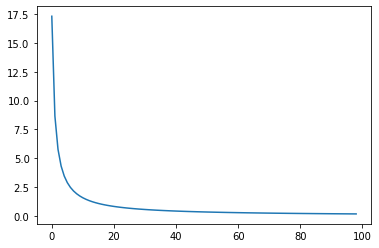

In [60]:
import matplotlib.pyplot as plt

P_ref = [0, 0, 0]
P = []
for i in range(1,100):
    p = [1/i*10, 1/i*10 ,1/i*10]
    P.append(p)
D = []
for p in P:
    d = distance(P_ref, p)
    D.append(d)
    
ys = D
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()
# Make sure to close the plt object once done
plt.close()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_excel('graveyard_tests_2.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9936 entries, 0 to 9935
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9936 non-null   int64  
 1   ofv1        9936 non-null   float64
 2   ofv2        9936 non-null   float64
 3   policy      9936 non-null   object 
 4   generation  9936 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 388.2+ KB


In [5]:
df.head()

,Unnamed: 0,ofv1,ofv2,policy,generation
0,0,-3.050428,3.919443,"year < 2291, net_output < 1273, miu_2140|sr_0....",0
1,1,-0.928801,3.882951,"mat < 1053, miu_2219|sr_0.26941103657892396|ir...",0
2,2,-0.625681,3.936420,"net_output < 72, miu_2226|sr_0.226201375804708...",0
3,3,-0.093950,3.992525,"mat < 1262, miu_2102|sr_0.4897403518518033|irs...",0
4,4,-1.197565,3.870720,"net_output < 1449, year < 2109, miu_2202|sr_0....",0


In [111]:
policy = df['policy'][0]

In [112]:
policy = policy.split(',')

indicators = []
actions = []
for pol in policy:
    if '<' in pol:
        indicators.append(pol)
    elif '|' in pol:
        actions.append(pol)

In [113]:
actions = [action.split(' ')[1] for action in actions]
actions = [actions.split('|') for actions in actions]

action_dict = {}
for act_ in actions:
    for act in act_:
        name, value = act.split('_')
        if name in action_dict.keys():
            action_dict[name].append(float(value))
        else:
            action_dict[name] = [value]

In [114]:
indicators = [indicator.strip(' ') for indicator in indicators]
indicators = [indicator.split(' < ') for indicator in indicators]

indicator_dict = {}
for ind in indicators:
    if ind[0] in indicator_dict.keys():
        indicator_dict[ind[0]].append(float(ind[1]))
    else:
        indicator_dict[ind[0]] = [ind[1]]

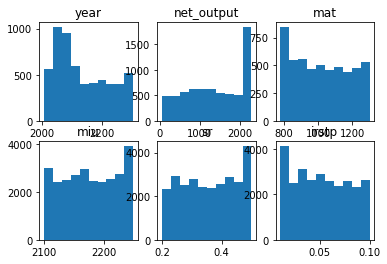

In [14]:
action_dict = {}
indicator_dict = {}
for policy_in_df in df['policy']:
    policy = policy_in_df.split(',')

    indicators = []
    actions = []
    for pol in policy:
        if '<' in pol:
            indicators.append(pol)
        elif '|' in pol:
            actions.append(pol)
            
    # Separate actions
    actions = [action.split(' ')[1] for action in actions]
    actions = [actions.split('|') for actions in actions]

    for act_ in actions:
        for act in act_:
            name, value = act.split('_')
            if name in action_dict.keys():
                action_dict[name].append(float(value))
            else:
                action_dict[name] = [float(value)]
    
    # Separate indicators
    indicators = [indicator.strip(' ') for indicator in indicators]
    indicators = [indicator.split(' < ') for indicator in indicators]

    for ind in indicators:
        if ind[0] in indicator_dict.keys():
            indicator_dict[ind[0]].append(float(ind[1]))
        else:
            indicator_dict[ind[0]] = [float(ind[1])]
            
plt.subplot(2, 3, 1)
y = np.array(indicator_dict['year'])
plt.hist(y);
plt.title('year')
# plt.ylabel('ofv2 - temp_overshoots')
# plt.xlabel('ofv1 - period utility')

plt.subplot(2, 3, 2)
y = np.array(indicator_dict['net_output'])
plt.hist(y);
plt.title('net_output')

plt.subplot(2, 3, 3)
y = np.array(indicator_dict['mat'])
plt.hist(y);
plt.title('mat')

plt.subplot(2, 3, 4)
y = np.array(action_dict['miu'])
plt.hist(y);
plt.title('miu')
# plt.ylabel('ofv2 - temp_overshoots')
# plt.xlabel('ofv1 - period utility')

plt.subplot(2, 3, 5)
y = np.array(action_dict['sr'])
plt.hist(y);
plt.title('sr')

plt.subplot(2, 3, 6)
y = np.array(action_dict['irstp'])
plt.hist(y);
plt.title('irstp')

plt.show()
plt.close()

In [1]:
import numpy
rng = numpy.random.default_rng(0)
out = [rng.choice([0, 1], p=[0.5, 0.5]) for _ in range(10)]
out

[1, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [2]:
rng = numpy.random.default_rng(0)
out = [rng.choice([0, 1], p=[0.5, 0.5]) for _ in range(10)]

In [3]:
out

[1, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [4]:
rng = numpy.random.default_rng(0)
out = [rng.choice([0, 1], p=[0.5, 0.5]) for _ in range(10)]
out

[1, 0, 0, 0, 1, 1, 1, 1, 1, 1]

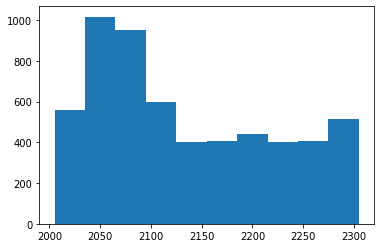

In [10]:
import matplotlib.pyplot as plt
import numpy as np
y = np.array(indicator_dict['year'])
plt.hist(y);
plt.show()

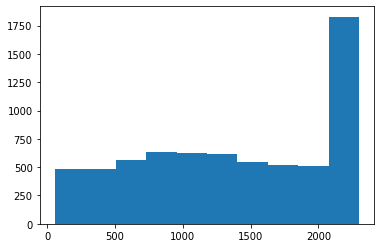

In [11]:
y = np.array(indicator_dict['net_output'])
plt.hist(y);
plt.show()

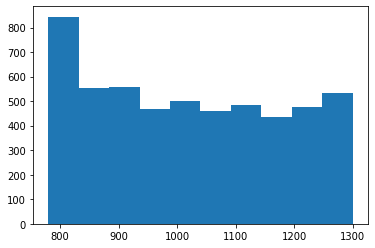

In [12]:
y = np.array(indicator_dict['mat'])
plt.hist(y);
plt.show()

In [9]:
indicator_dict

{'year': [2291.0,
  2109.0,
  2298.0,
  2091.0,
  2029.0,
  2224.0,
  2213.0,
  2256.0,
  2007.0,
  2194.0,
  2221.0,
  2275.0,
  2194.0,
  2108.0,
  2107.0,
  2256.0,
  2206.0,
  2087.0,
  2212.0,
  2221.0,
  2237.0,
  2213.0,
  2274.0,
  2194.0,
  2107.0,
  2283.0,
  2256.0,
  2065.0,
  2224.0,
  2213.0,
  2147.0,
  2035.0,
  2194.0,
  2086.0,
  2305.0,
  2109.0,
  2091.0,
  2079.0,
  2098.0,
  2127.0,
  2091.0,
  2028.0,
  2215.0,
  2305.0,
  2194.0,
  2256.0,
  2256.0,
  2107.0,
  2109.0,
  2107.0,
  2213.0,
  2194.0,
  2108.0,
  2070.0,
  2213.0,
  2284.0,
  2121.0,
  2108.0,
  2298.0,
  2213.0,
  2275.0,
  2194.0,
  2224.0,
  2291.0,
  2103.0,
  2101.0,
  2256.0,
  2005.0,
  2160.0,
  2254.0,
  2194.0,
  2273.0,
  2291.0,
  2007.0,
  2203.0,
  2137.0,
  2050.0,
  2204.0,
  2124.0,
  2139.0,
  2010.0,
  2147.0,
  2030.0,
  2147.0,
  2171.0,
  2156.0,
  2033.0,
  2030.0,
  2005.0,
  2204.0,
  2030.0,
  2030.0,
  2029.0,
  2050.0,
  2124.0,
  2005.0,
  2171.0,
  2170.0,
  2133.0,
  